------------------------Students Expenditure Predictor------------------------

Importing Libraries and Loading Excel File

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load Excel file
df = pd.read_excel("Student Expenditure Survey.xlsx")

df.head(121)

,Current Year of Study,Gender,Accommodation Status,laundry,daily commute,distance,Transport cost,expense on meal OUTSIDE?,miscellaneous expense,monthly income/funds?,monthly expenditure? (PKR),income per month? (pocket money / salary)
0,Sophomore (2nd Year),Female,Hostelite,Self,Walking,1.0,0,10000,10000,Pocket Money,35000,30000
1,Senior (4th Year),Male,Day Scholar,Self,Private Transport,30.5,16200,3000,5000,Freelancing,30000,40000
2,Junior (3rd Year),Female,Hostelite,External,Private Transport,4.5,4000,3000,8000,Pocket Money,35000,40000
3,Sophomore (2nd Year),Male,Day Scholar,Self,Private Transport,18.0,6000,2000,1000,Pocket Money,2000,20000
4,Freshman (1st Year),Male,Hostelite,External,Indrive,15.0,6000,2000,3500,Pocket Money,35000,24000
...,...,...,...,...,...,...,...,...,...,...,...,...
114,Junior (3rd Year),Male,Day Scholar,Self,Public Transport,12.0,10000,3000,2000,Pocket Money,20000,130000
115,Freshman (1st Year),Female,Hostelite,External,Public Transport,2.0,3000,7000,15000,Pocket Money,70000,150000
116,Junior (3rd Year),Male,Day Scholar,Self,University Bus,90.0,1,3500,25000,Pocket Money,60000,150000
117,Sophomore (2nd Year),Male,Day Scholar,Self,Private Transport,20.0,20000,2500,25000,Pocket Money,40000,200000


Clean Column Names

In [ ]:
# Clean column names by stripping leading/trailing whitespace
df.columns = df.columns.str.strip()

# Display the column names and the first few rows to verify
print("Cleaned Column Names:", df.columns.tolist())
print("\nFirst 5 rows of the data:")
print(df.head())

Cleaned Column Names: ['Current Year of Study', 'Gender', 'Accommodation Status', 'laundry', 'daily commute', 'distance', 'Transport cost', 'expense on meal OUTSIDE?', 'miscellaneous expense', 'monthly income/funds?', 'monthly expenditure? (PKR)', 'income per month? (pocket money / salary)']

First 5 rows of the data:
  Current Year of Study  Gender Accommodation Status   laundry  \
0  Sophomore (2nd Year)  Female            Hostelite      Self   
1     Senior (4th Year)    Male          Day Scholar      Self   
2     Junior (3rd Year)  Female            Hostelite  External   
3  Sophomore (2nd Year)    Male          Day Scholar      Self   
4   Freshman (1st Year)    Male            Hostelite  External   

       daily commute  distance  Transport cost  expense on meal OUTSIDE?  \
0            Walking       1.0               0                     10000   
1  Private Transport      30.5           16200                      3000   
2  Private Transport       4.5            4000         

**Step 3: Handle Outliers in "distance" based on "daily commute"**

This block handles outliers by calculating the Interquartile Range (IQR) specifically for each daily commute category. It then filters out any rows where the distance is unreasonably high or low for that specific mode of transport (e.g., removing the 50km value for "Walking").

In [ ]:
# 1. Calculate Q1 and Q3 for 'distance' grouped by 'daily commute'
Q1 = df.groupby('daily commute')['distance'].transform(lambda x: x.quantile(0.25))
Q3 = df.groupby('daily commute')['distance'].transform(lambda x: x.quantile(0.75))

# 2. Calculate the Interquartile Range (IQR)
IQR = Q3 - Q1

# 3. Define the bounds
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# 4. Identify the outliers
# An outlier is any value less than the lower bound OR greater than the upper bound
outlier_mask = (df['distance'] < lower_bound) | (df['distance'] > upper_bound)

print(f"Found {outlier_mask.sum()} outliers in Distance. Replacing with median...")

# 5. Calculate the median for each group
# This creates a series of the same size as the dataframe with the group median for each row
medians = df.groupby('daily commute')['distance'].transform('median')

# 6. Replace the outliers
# We only update the rows where outlier_mask is True
df.loc[outlier_mask, 'distance'] = medians[outlier_mask]

# Verify the result
print("\nDistance stats after replacement:")
print(df.groupby('daily commute')['distance'].describe())

Found 7 outliers in Distance. Replacing with median...

Distance stats after replacement:
                   count       mean        std  min     25%    50%    75%  \
daily commute                                                               
Indrive             10.0   4.560000   4.168719  1.5   2.125   3.00   5.25   
Private Transport   51.0  15.811765   9.219060  4.0   7.400  14.00  23.00   
Public Transport    21.0  12.885714   9.350416  0.0   6.000  12.00  17.00   
University Bus      19.0  22.163158  10.095940  6.5  14.500  23.00  31.75   
Walking             18.0   1.205556   0.894738  0.0   0.325   1.25   2.00   

                    max  
daily commute            
Indrive            15.0  
Private Transport  36.9  
Public Transport   35.0  
University Bus     40.0  
Walking             3.0  


**Step 4 : Fix Walking Cost & Clean Transport Cost**
Set Cost to 0 for Walking: This explicitly forces the cost to be 0 for 'Walking', fixing any bad data entry (e.g., someone entered 1000 by mistake).

Handle Outliers: The code calculates the normal range (IQR) for each transport type and replaces with median.

In [ ]:
# 1. Correct the Transport Cost for 'Walking' to 0
# (We do this BEFORE outlier detection to correct obvious errors first)
df.loc[df['daily commute'] == 'Walking', 'Transport cost'] = 0

# 2. Calculate Q1 and Q3 for 'Transport cost'
Q1_cost = df.groupby('daily commute')['Transport cost'].transform(lambda x: x.quantile(0.25))
Q3_cost = df.groupby('daily commute')['Transport cost'].transform(lambda x: x.quantile(0.75))

# 3. Calculate IQR
IQR_cost = Q3_cost - Q1_cost

# 4. Define bounds
lower_bound_cost = Q1_cost - 1.5 * IQR_cost
upper_bound_cost = Q3_cost + 1.5 * IQR_cost

# 5. Identify the outliers
outlier_mask_cost = (df['Transport cost'] < lower_bound_cost) | (df['Transport cost'] > upper_bound_cost)

print(f"Found {outlier_mask_cost.sum()} outliers in Transport Cost. Replacing with median...")

# 6. Calculate the median for each group
medians_cost = df.groupby('daily commute')['Transport cost'].transform('median')

# 7. Replace the outliers
# We only update the rows where outlier_mask_cost is True
df.loc[outlier_mask_cost, 'Transport cost'] = medians_cost[outlier_mask_cost]

# Final check
print("\nTransport Cost stats after replacement:")
print(df.groupby('daily commute')['Transport cost'].describe())

Found 9 outliers in Transport Cost. Replacing with median...

Transport Cost stats after replacement:
                   count         mean          std     min     25%     50%  \
daily commute                                                                
Indrive             10.0  4901.000000  2662.540349    10.0  3500.0  6000.0   
Private Transport   51.0  9180.882353  6581.188320    25.0  4000.0  8000.0   
Public Transport    21.0  7523.809524  3919.426586  1000.0  4000.0  9000.0   
University Bus      19.0  7778.947368  1812.174552  4000.0  7000.0  7500.0   
Walking             18.0     0.000000     0.000000     0.0     0.0     0.0   

                       75%      max  
daily commute                        
Indrive             6750.0   8000.0  
Private Transport  12000.0  25000.0  
Public Transport   10000.0  15000.0  
University Bus      8750.0  12000.0  
Walking                0.0      0.0  


**Step 5: Clean "income per month" based on "monthly income/funds"**

This block applies the same outlier removal logic (IQR method) to the income per month column, grouped by whether the money comes from Pocket Money or Freelancing.

In [ ]:
# Define column names for easier access
income_col = 'income per month? (pocket money / salary)'
source_col = 'monthly income/funds?'

# 1. Calculate Q1 and Q3 for 'income per month' grouped by source
Q1_inc = df.groupby(source_col)[income_col].transform(lambda x: x.quantile(0.25))
Q3_inc = df.groupby(source_col)[income_col].transform(lambda x: x.quantile(0.75))

# 2. Calculate IQR and bounds
IQR_inc = Q3_inc - Q1_inc
lower_bound_inc = Q1_inc - 1.5 * IQR_inc
upper_bound_inc = Q3_inc + 1.5 * IQR_inc

# 3. Identify the outliers
# A row is an outlier if it is outside the bounds
outlier_mask = (df[income_col] < lower_bound_inc) | (df[income_col] > upper_bound_inc)

print(f"Found {outlier_mask.sum()} outliers in '{income_col}'. Replacing them with median...")

# 4. Calculate the median for each group
# This creates a series of the same length as the dataframe with the median of the corresponding group for each row
medians = df.groupby(source_col)[income_col].transform('median')

# 5. Replace outliers with the median
# We use .loc to only update the rows where outlier_mask is True
df.loc[outlier_mask, income_col] = medians[outlier_mask]

# Verify the changes
print("\nIncome stats after replacing outliers:")
print(df.groupby(source_col)[income_col].describe())

Found 11 outliers in 'income per month? (pocket money / salary)'. Replacing them with median...

Income stats after replacing outliers:
                       count          mean           std     min      25%  \
monthly income/funds?                                                       
Freelancing             17.0  20941.176471  15253.977302  4000.0  10000.0   
Pocket Money           102.0  19000.450980  16280.722058     1.0   8000.0   

                           50%      75%      max  
monthly income/funds?                             
Freelancing            16000.0  30000.0  50000.0  
Pocket Money           15000.0  25000.0  70000.0  


**Step 6: Clean "expense on meal OUTSIDE" based on "Accommodation Status"**

For this column, we will use "Accommodation Status" (Day Scholar vs. Hostelite) as the corresponding category, as it significantly impacts meal expenses.

This block performs the same operation as the previous step: it identifies outliers using the IQR method and replaces them with the median of their respective group.

In [ ]:
# Define columns
meal_col = 'expense on meal OUTSIDE?'
group_col = 'Accommodation Status'

# 1. Calculate Q1 and Q3
Q1_meal = df.groupby(group_col)[meal_col].transform(lambda x: x.quantile(0.25))
Q3_meal = df.groupby(group_col)[meal_col].transform(lambda x: x.quantile(0.75))

# 2. Calculate IQR and bounds
IQR_meal = Q3_meal - Q1_meal
lower_bound_meal = Q1_meal - 1.5 * IQR_meal
upper_bound_meal = Q3_meal + 1.5 * IQR_meal

# 3. Identify outliers
outlier_mask_meal = (df[meal_col] < lower_bound_meal) | (df[meal_col] > upper_bound_meal)

print(f"Found {outlier_mask_meal.sum()} outliers in '{meal_col}'. Replacing with median...")

# 4. Calculate medians for replacement
medians_meal = df.groupby(group_col)[meal_col].transform('median')

# 5. Replace outliers
df.loc[outlier_mask_meal, meal_col] = medians_meal[outlier_mask_meal]

# Verify the result
print("\nMeal Expense stats after cleaning:")
print(df.groupby(group_col)[meal_col].describe())

Found 7 outliers in 'expense on meal OUTSIDE?'. Replacing with median...

Meal Expense stats after cleaning:
                      count         mean          std  min     25%     50%  \
Accommodation Status                                                         
Day Scholar            76.0  2285.526316  1392.810487  0.0  1500.0  2000.0   
Hostelite              43.0  3197.674419  2839.558012  0.0  1000.0  2500.0   

                         75%      max  
Accommodation Status                   
Day Scholar           3000.0   5000.0  
Hostelite             5000.0  10000.0  


**Step 7: Clean "monthly expenditure" based on "Accommodation Status"**

For "monthly expenditure", the best corresponding category is "Accommodation Status" (Day Scholar vs. Hostelite), as hostelites generally have higher living costs.

This code will identify outliers in the expenditure column for each group and replace them with the median.

In [ ]:
# Define columns
expenditure_col = 'monthly expenditure? (PKR)'
group_col = 'Accommodation Status'

# 1. Calculate Q1 and Q3 for 'monthly expenditure'
Q1_exp = df.groupby(group_col)[expenditure_col].transform(lambda x: x.quantile(0.25))
Q3_exp = df.groupby(group_col)[expenditure_col].transform(lambda x: x.quantile(0.75))

# 2. Calculate IQR
IQR_exp = Q3_exp - Q1_exp

# 3. Define bounds
lower_bound_exp = Q1_exp - 1.5 * IQR_exp
upper_bound_exp = Q3_exp + 1.5 * IQR_exp

# 4. Identify outliers
outlier_mask_exp = (df[expenditure_col] < lower_bound_exp) | (df[expenditure_col] > upper_bound_exp)

print(f"Found {outlier_mask_exp.sum()} outliers in '{expenditure_col}'. Replacing with median...")

# 5. Calculate medians for replacement
medians_exp = df.groupby(group_col)[expenditure_col].transform('median')

# 6. Replace outliers
df.loc[outlier_mask_exp, expenditure_col] = medians_exp[outlier_mask_exp]

# Verify the result
print("\nMonthly Expenditure stats after cleaning:")
print(df.groupby(group_col)[expenditure_col].describe())

# Save the final cleaned data to a CSV file (optional but recommended)
df.to_csv("Student_Expenditure_Cleaned.csv", index=False)
print("\nFinal cleaned dataset saved as 'Student_Expenditure_Cleaned.csv'")

Found 6 outliers in 'monthly expenditure? (PKR)'. Replacing with median...

Monthly Expenditure stats after cleaning:
                      count          mean           std     min      25%  \
Accommodation Status                                                       
Day Scholar            76.0  17789.473684   9959.338384  2000.0  10000.0   
Hostelite              43.0  31139.534884  10864.054745  9000.0  24000.0   

                          50%      75%      max  
Accommodation Status                             
Day Scholar           15000.0  25000.0  40000.0  
Hostelite             35000.0  35000.0  50000.0  

Final cleaned dataset saved as 'Student_Expenditure_Cleaned.csv'


## **Exploratory Data Analysis**

**Step 1: Import Visualization Libraries**


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="whitegrid")
plt.figure(figsize=(10, 6))

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

**Step 2: Descriptive Statistics**

This gives you a quick statistical summary (Mean, Median, Min, Max) of all the numerical columns you have cleaned.

In [ ]:
# Select the numerical columns we cleaned
numerical_cols = [
    'distance',
    'Transport cost',
    'expense on meal OUTSIDE?',
    'monthly expenditure? (PKR)',
    'income per month? (pocket money / salary)'
]

# Display summary statistics
print(df[numerical_cols].describe())

         distance  Transport cost  expense on meal OUTSIDE?  \
count  119.000000      119.000000                 119.00000   
mean    13.154622     6916.260504                2615.12605   
std     10.582651     5660.475710                2072.81184   
min      0.000000        0.000000                   0.00000   
25%      4.250000     3000.000000                1450.00000   
50%     11.000000     7000.000000                2000.00000   
75%     19.500000     9500.000000                3000.00000   
max     40.000000    25000.000000               10000.00000   

       monthly expenditure? (PKR)  income per month? (pocket money / salary)  
count                  119.000000                                 119.000000  
mean                 22613.445378                               19277.697479  
std                  12105.020141                               16090.073847  
min                   2000.000000                                   1.000000  
25%                  13500.000000    

**Step 3: Visualize Distributions (Histograms)**

This block creates a histogram for each numerical column to show the distribution of data (e.g., are most transport costs low or high?).

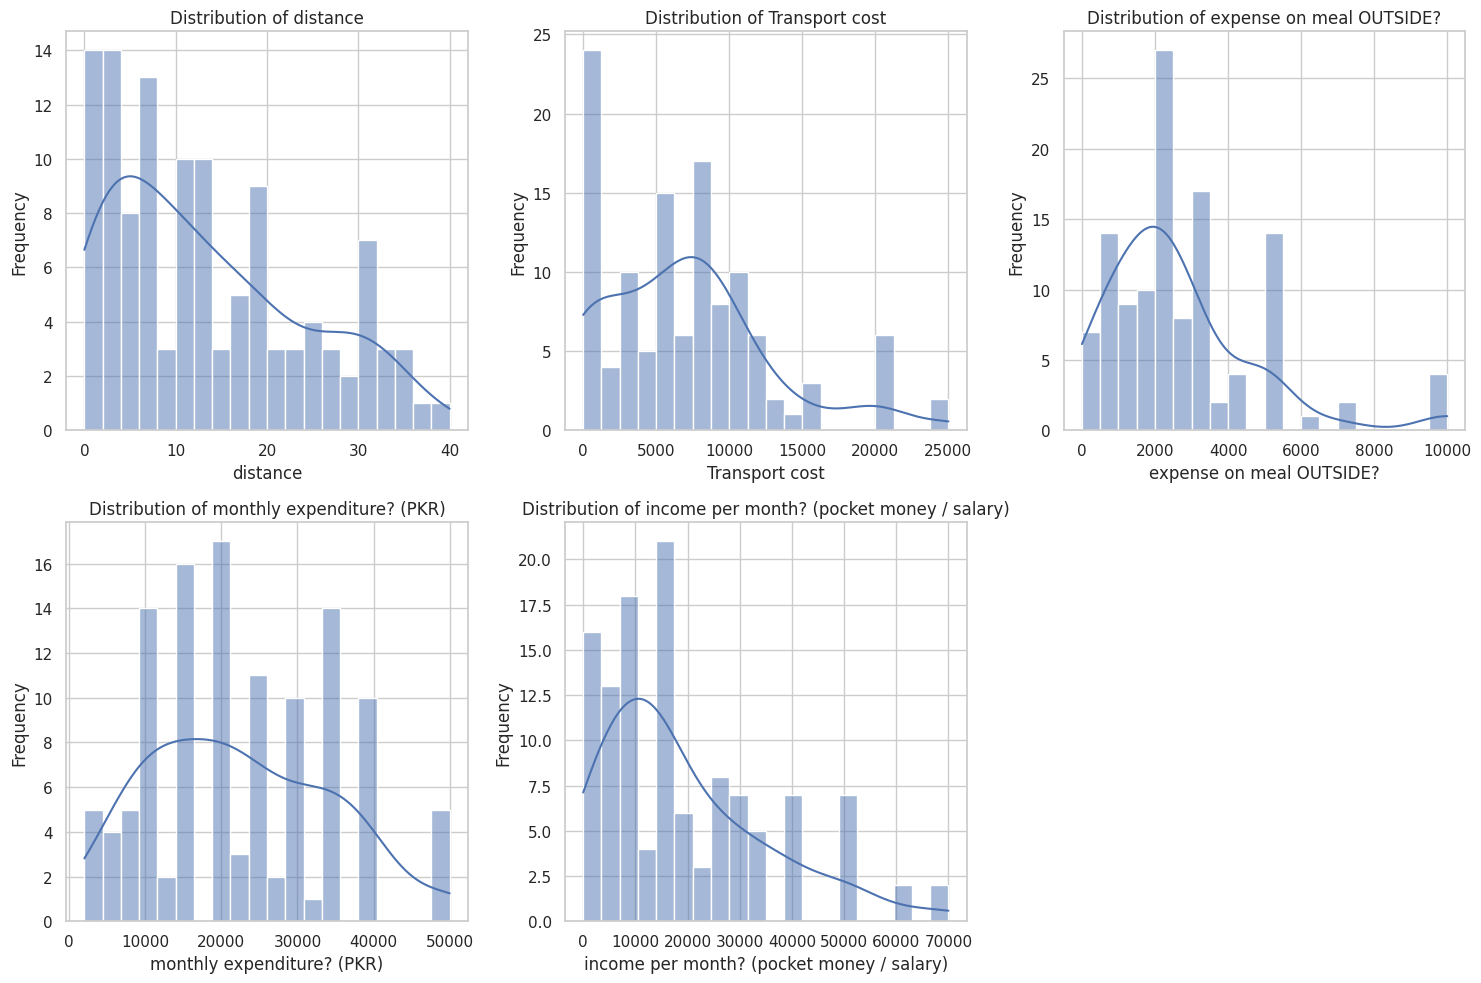

In [ ]:
# Plot histograms for each numerical column
plt.figure(figsize=(15, 10))

for i, col in enumerate(numerical_cols, 1):
    plt.subplot(2, 3, i)
    sns.histplot(df[col], kde=True, bins=20)
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

**Step 4: Boxplot**

It shows how expenses differ based on categories like Accommodation Status.

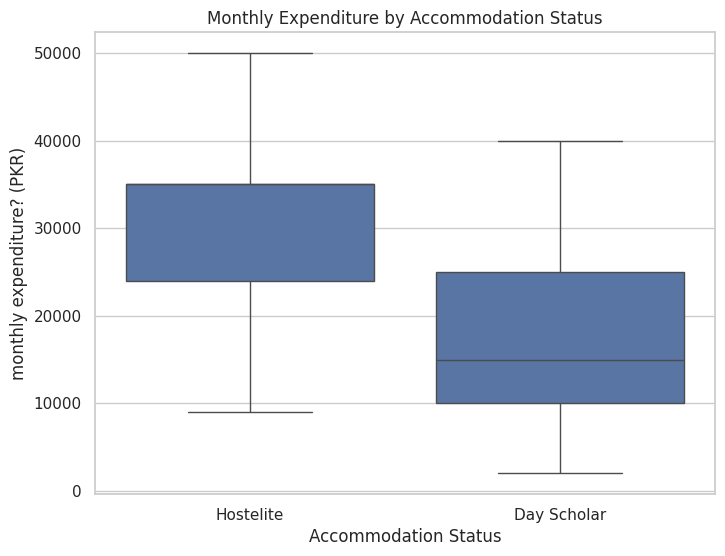

In [ ]:


#Monthly Expenditure vs Accommodation Status
plt.figure(figsize=(8, 6))
sns.boxplot(x='Accommodation Status', y='monthly expenditure? (PKR)', data=df)
plt.title('Monthly Expenditure by Accommodation Status')
plt.show()

**Step 5: Correlation Heatmap**

This shows if there are any relationships between the variables (e.g., does higher income correlate with higher expenditure?).

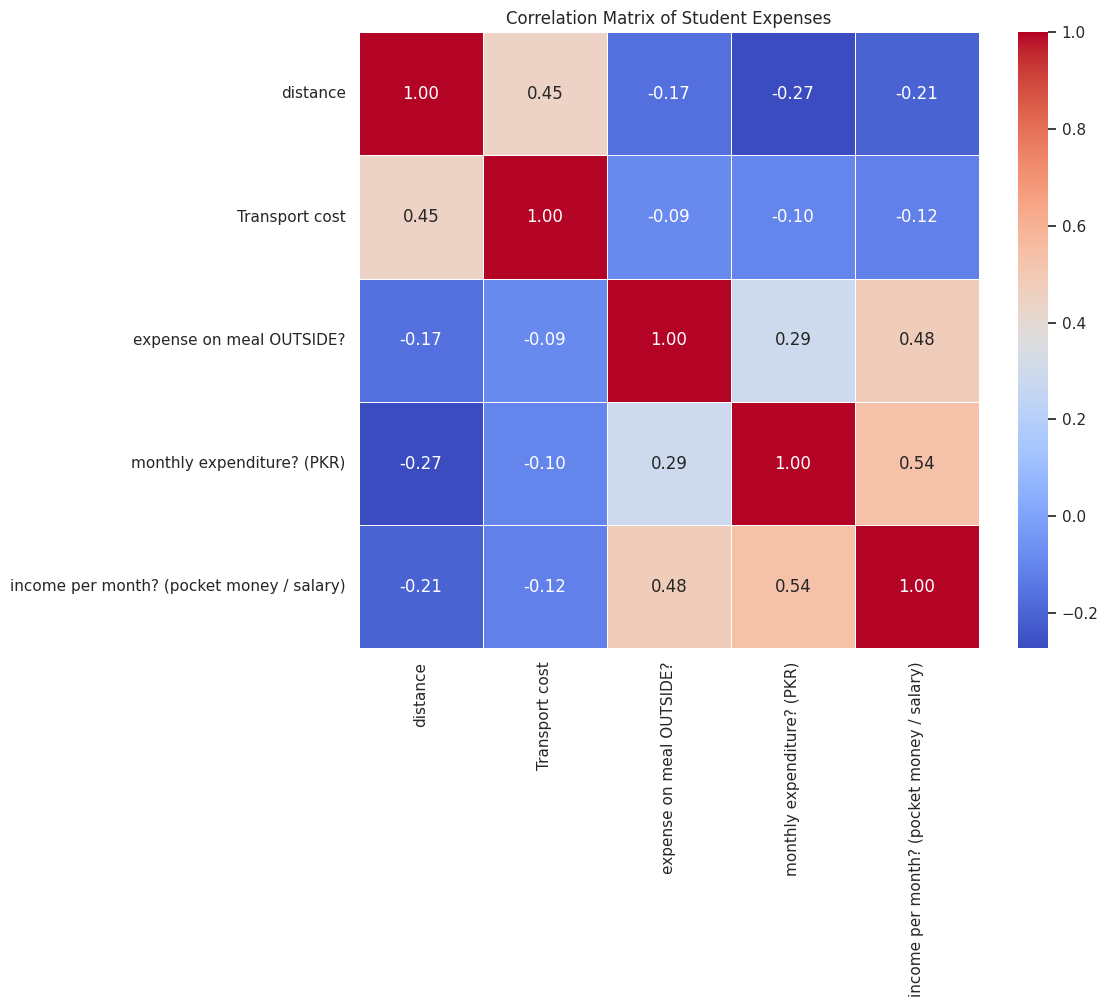

In [ ]:
# Calculate correlation matrix
corr_matrix = df[numerical_cols].corr()

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix of Student Expenses')
plt.show()

**Step 6: Income vs Expenditure**

This histogram will show the distribution of savings. If the graph is skewed to the left (negative), it proves that many students struggle with their budget.



In [ ]:
# 1. Calculate 'Savings' (Income - Expenditure)
# A negative value means the student is in deficit (spending more than they earn/get)
df['Savings'] = df['income per month? (pocket money / salary)'] - df['monthly expenditure? (PKR)']

# 2. Calculate Expense Ratios (What % of budget goes where?)
df['Transport_Share'] = df['Transport cost'] / df['monthly expenditure? (PKR)']
df['Food_Share'] = df['expense on meal OUTSIDE?'] / df['monthly expenditure? (PKR)']

# Display the new columns to verify
print(df[['Current Year of Study', 'Savings', 'Transport_Share', 'Food_Share']].head())

# Quick check: How many students are in deficit?
deficit_count = len(df[df['Savings'] < 0])
total_count = len(df)
print(f"\nStudents in Deficit: {deficit_count} out of {total_count} ({deficit_count/total_count:.1%})")

  Current Year of Study  Savings  Transport_Share  Food_Share
0  Sophomore (2nd Year)    -5000         0.000000    0.285714
1     Senior (4th Year)    10000         0.540000    0.100000
2     Junior (3rd Year)     5000         0.114286    0.085714
3  Sophomore (2nd Year)    18000         3.000000    1.000000
4   Freshman (1st Year)   -11000         0.171429    0.057143

Students in Deficit: 56 out of 119 (47.1%)


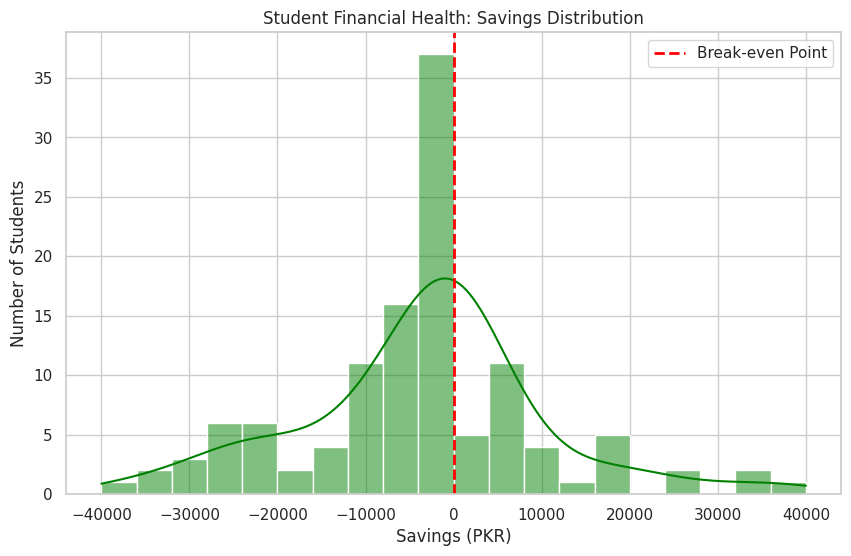

In [ ]:
plt.figure(figsize=(10, 6))

# Plot the distribution of Savings
sns.histplot(df['Savings'], kde=True, color='green', bins=20)

# Add a vertical line at 0 to separate Savers from Spenders
plt.axvline(0, color='red', linestyle='--', linewidth=2, label='Break-even Point')

plt.title('Student Financial Health: Savings Distribution')
plt.xlabel('Savings (PKR)')
plt.ylabel('Number of Students')
plt.legend()
plt.show()

**Step 7: Comparative Analysis (Hostelite vs. Day Scholar)**
This is a powerful insight: Day Scholars spend a huge chunk of money on Transport, while Hostelites save on that but might spend elsewhere. This code visualizes that trade-off.

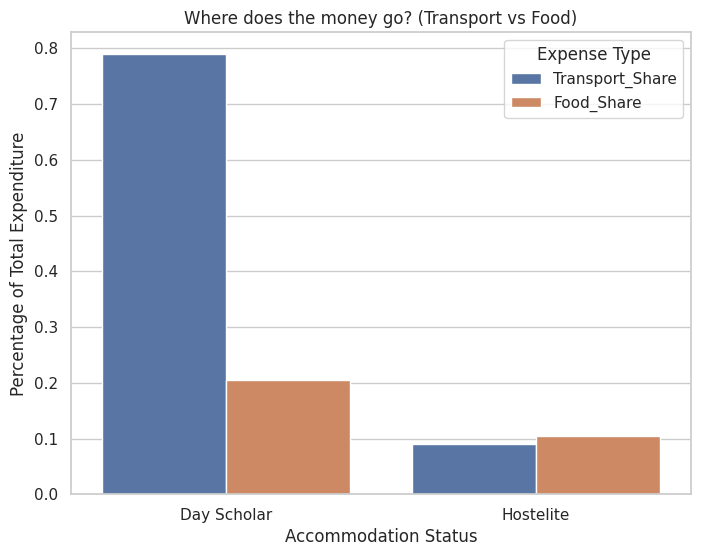

In [ ]:
# Group by Accommodation Status and calculate average shares
spending_habits = df.groupby('Accommodation Status')[['Transport_Share', 'Food_Share']].mean().reset_index()

# Melt the data for easier plotting with Seaborn
spending_melted = spending_habits.melt(id_vars='Accommodation Status', var_name='Expense Type', value_name='Share of Budget')

plt.figure(figsize=(8, 6))
sns.barplot(x='Accommodation Status', y='Share of Budget', hue='Expense Type', data=spending_melted)

plt.title('Where does the money go? (Transport vs Food)')
plt.ylabel('Percentage of Total Expenditure')
plt.show()

**Step 8: Lifecycle Trends (Freshman to Senior)**

Does money management get better as students get older? This plot compares the median Income and Expenditure across the 4 years of study.

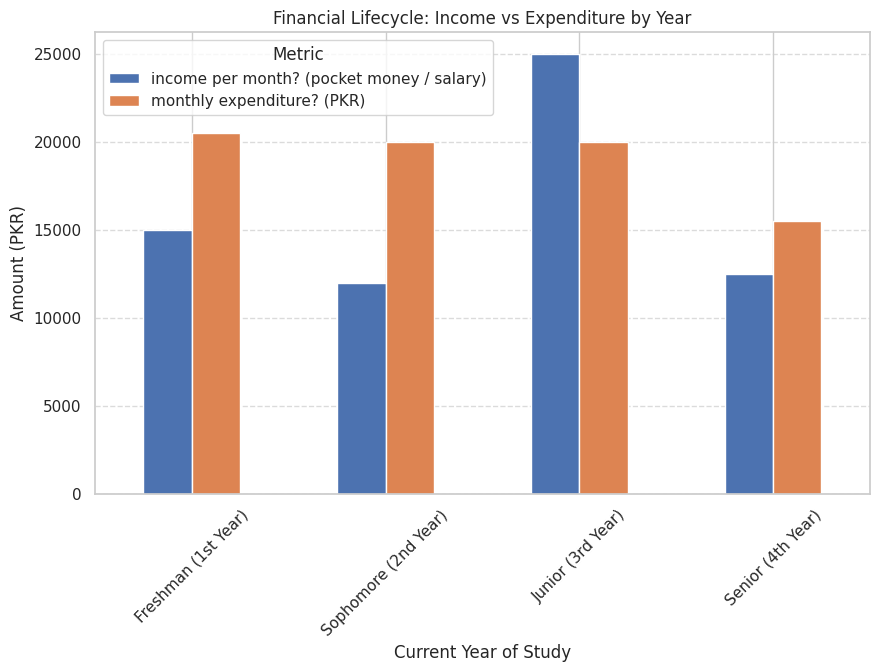

In [ ]:
# Order the years correctly
order_years = ['Freshman (1st Year)', 'Sophomore (2nd Year)', 'Junior (3rd Year)', 'Senior (4th Year)']

# Calculate Median Income and Expenditure per Year
year_trends = df.groupby('Current Year of Study')[['income per month? (pocket money / salary)', 'monthly expenditure? (PKR)']].median()
year_trends = year_trends.reindex(order_years)

# Plotting
year_trends.plot(kind='bar', figsize=(10, 6))
plt.title('Financial Lifecycle: Income vs Expenditure by Year')
plt.ylabel('Amount (PKR)')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(title='Metric')
plt.show()

# **Student Expenditure Calculator**

**Step 1: Build and Train the Model**

This code builds a Machine Learning Calculator using the Random Forest algorithm. It learns from your cleaned data to predict the monthly budget for any student profile.

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# 1. Define Features and Target
# We use these 4 inputs to predict the budget
features = ['Accommodation Status', 'daily commute', 'Current Year of Study', 'distance']
target = 'monthly expenditure? (PKR)'

X = df[features]
y = df[target]

# 2. Create a Preprocessing Pipeline
# We need to turn text (like 'Hostelite') into numbers for the AI
categorical_features = ['Accommodation Status', 'daily commute', 'Current Year of Study']
numerical_features = ['distance']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

# 3. Create the Model Pipeline
# We use a Random Forest, which is good at handling complex data
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(n_estimators=100, random_state=42))
])

# 4. Train the Model
model.fit(X, y)

print("Calculator is trained and ready!")

Calculator is trained and ready!


**Step 2: Use the Calculator**



In [ ]:
def interactive_budget_calculator():
    print("--- Student Budget Calculator ---")
    print("Please answer the following questions to predict your monthly budget.\n")

    # 1. Get Accommodation Status
    print("1. Accommodation Status (Enter 'Hostelite' or 'Day Scholar'):")
    accommodation = input().strip()

    # 2. Get Commute Method
    print("\n2. Daily Commute (Enter 'Walking', 'University Bus', 'Public Transport', 'Private Transport', or 'Indrive'):")
    commute = input().strip()

    # 3. Get Year of Study
    print("\n3. Current Year of Study (e.g., 'Freshman (1st Year)', 'Sophomore (2nd Year)', 'Junior (3rd Year)', 'Senior (4th Year)'):")
    year = input().strip()

    # 4. Get Distance
    print("\n4. One-way Distance to University (in km, e.g., 5.5):")
    try:
        distance = float(input().strip())
    except ValueError:
        print("Invalid distance. Using default of 10km.")
        distance = 10.0

    # Create the dataframe for the model
    input_data = pd.DataFrame({
        'Accommodation Status': [accommodation],
        'daily commute': [commute],
        'Current Year of Study': [year],
        'distance': [distance]
    })

    # Predict
    try:
        predicted_cost = model.predict(input_data)[0]
        print("\n" + "="*40)
        print(f"💰 Estimated Monthly Budget: PKR {predicted_cost:,.0f}")
        print("="*40)
    except Exception as e:
        print(f"\nError in prediction: {e}")
        print("Please check if you entered the category names exactly as shown.")

# Run the calculator
interactive_budget_calculator()

--- Student Budget Calculator ---
Please answer the following questions to predict your monthly budget.

1. Accommodation Status (Enter 'Hostelite' or 'Day Scholar'):
Day Scholar

2. Daily Commute (Enter 'Walking', 'University Bus', 'Public Transport', 'Private Transport', or 'Indrive'):
Public Transport

3. Current Year of Study (e.g., 'Freshman (1st Year)', 'Sophomore (2nd Year)', 'Junior (3rd Year)', 'Senior (4th Year)'):
Sophomore (2nd Year)

4. One-way Distance to University (in km, e.g., 5.5):
20

💰 Estimated Monthly Budget: PKR 23,133
